## Final Project - Network Data Science 
#### Vignesh Vanchinathan, Jan 2023, Johns Hopkins

An analysis of the network of yeast operons. How do particular genes affect others? Which are more connected?


### Import Data
[Yeast Transcription Data](https://networks.skewed.de/net/yeast_transcription)
[Representation of edges](https://www.science.org/doi/10.1126/science.298.5594.824)

Basic info: 916 nodes, 1094 edges, directed

Node: a particular gene that is transcribed (e.g. ASP3D)

Edge: a connection between genes; X->Y implies that X's products regulates Y


In [2]:
import networkx as nx
from graspologic.plot import adjplot, networkplot, heatmap
from graspologic.partition import leiden, modularity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [20]:
g = nx.read_weighted_edgelist("network.csv/edges.csv", delimiter = ",", create_using = nx.DiGraph())
undirected = nx.read_weighted_edgelist("network.csv/edges.csv", delimiter = ",", create_using = nx.Graph()) #for analysis of communities

edges = pd.read_csv("network.csv/edges.csv")
nodes = pd.read_csv("network.csv/nodes.csv") #list of corresponding genes for nodes


In [16]:
#establish nodes_df for future visualizations
nodesList = list(g.nodes)
nodes_df = pd.DataFrame(index = nodesList)

pos = nx.kamada_kawai_layout(g)

x = []
y = []

for node in list(g.nodes):
    x.append(pos[node][0])
    y.append(pos[node][1])

x = np.array(x)
nodes_df["x"] = x

y = np.array(y)
nodes_df["y"] = y

print(nodes_df)


            x         y
1   -0.163988 -0.232719
236  0.046928 -0.262426
3    0.132433 -0.174006
281  0.160979  0.038050
4   -0.360143  0.225794
..        ...       ...
901  0.395820  0.374109
902  0.395920  0.376115
903  0.396003  0.378152
904  0.396066  0.380185
905  0.041817 -0.006824

[690 rows x 2 columns]


### Visualization
We represent the TF network data as an adjacency matrix using a Numpy array

In [10]:
A = nx.to_numpy_array(g)
B = nx.to_numpy_array(undirected)

print(nx.is_directed(g))
print(nx.is_directed(undirected))

True
False


(<AxesSubplot: >,
 <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x10621b5b0>)

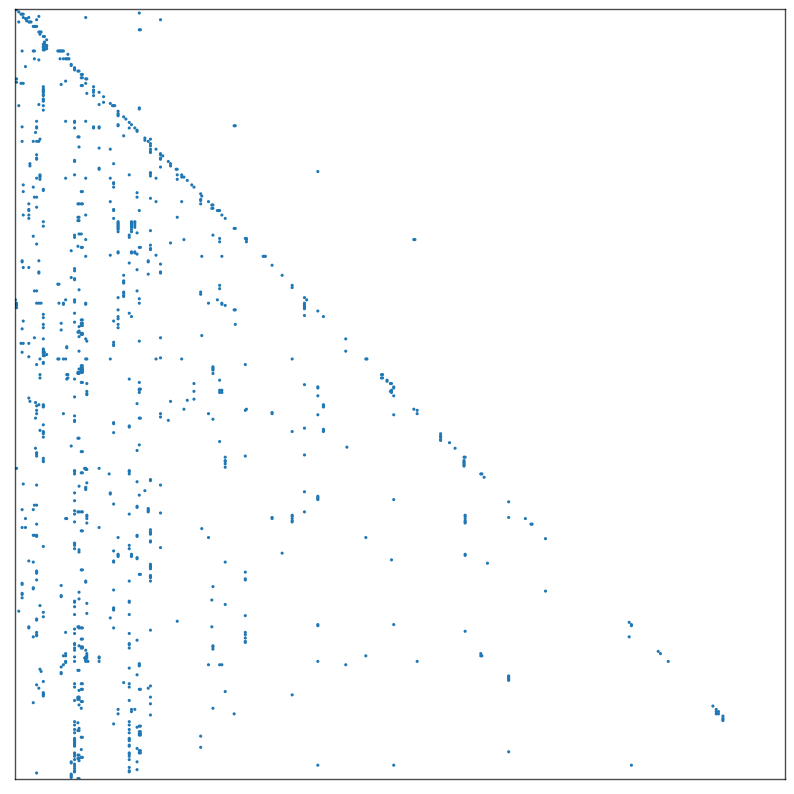

In [11]:
adjplot(A, plot_type="scattermap", sizes=(5, 5))

Notice that points sometimes fall in vertical lines which suggests that an inherent pattern in how the data was organized. (Vertical line implies one gene has a lot of reulatory data points).

In [12]:
nodePos = nx.kamada_kawai_layout(g)

#plot
fig, ax = plt.subplots(1, 1, figsize = (100, 100))
nx.draw_networkx(g, pos = nodePos, ax = ax)

#TODO, add gene names to graph points


Interesting phenomenon: Seemingly there are clusters near the center, some multigene networks, and even genes that connect to, and therefore regulate, themselves. This could indicate a negative feedback loop.

### Modularity and Community Detection

We can now try to look at communities within the dataset, as this is a logical step in the study of interacting genes. This will reveal clusters of genes that interact with one another, hopefully identifying groups that have a common function within the cell.

<AxesSubplot: >

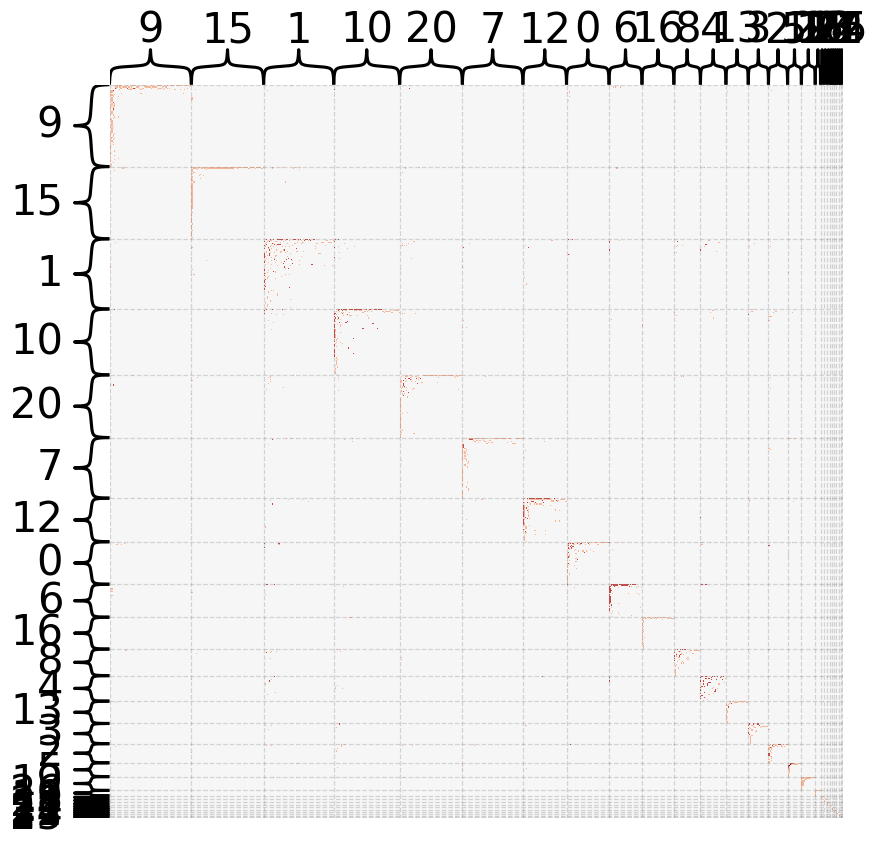

In [13]:
#using undirected adj matrix
partition_map = leiden(undirected, trials=100)

nodelist = list(undirected.nodes)
labels = np.vectorize(partition_map.get)(nodelist)

heatmap(B, inner_hier_labels=labels, sort_nodes=True, cbar=False)


There are many smaller communities within the larger dataset. This possibly implies that there are many modular gene networks that are connected to each other within the transcriptome.


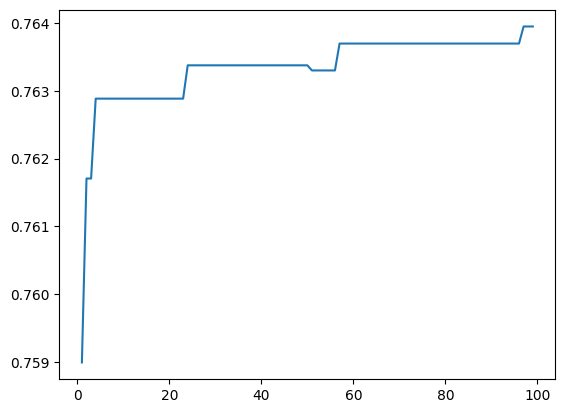

In [25]:
fix, ax = plt.subplots(1, 1)

x = []
y = []
for n in range(1, 100):
    part_map = leiden(undirected, random_seed = 4, trials = n)
    mod = modularity(undirected, part_map)
    x.append(n)
    y.append(mod)

plt.plot(x, y)

part_map = leiden(undirected, random_seed = 4, trials = n, resolution=0.20)
nodes_df["leiden_community"] = part_map

Converges to a high amount of modularity! Let's look at a visualization of the network. (this plot isn't actually that useful I just wanted to play around with it)

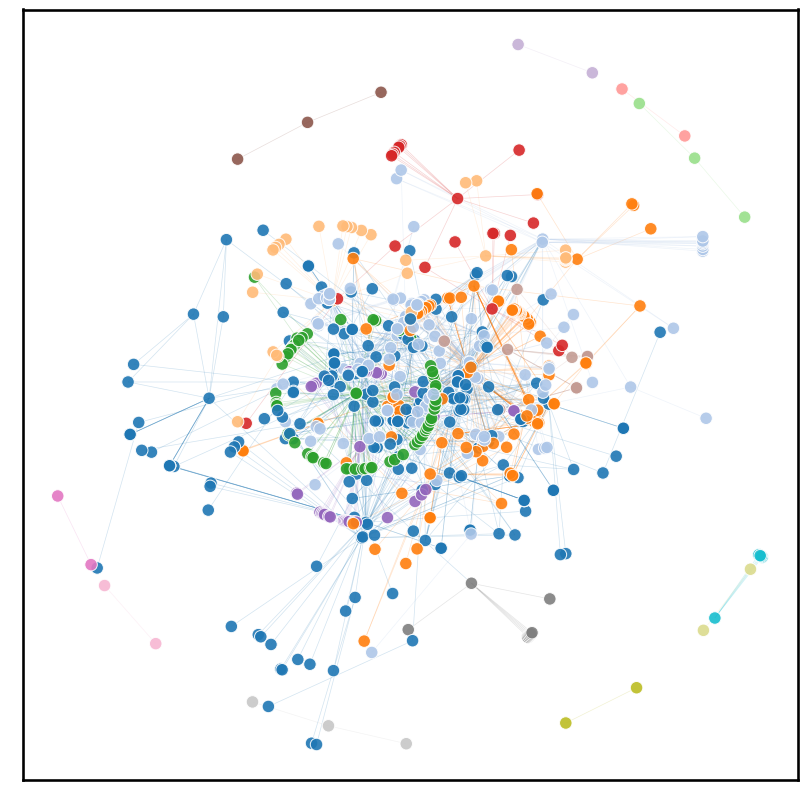

In [26]:
def plot_network_partition(adj, node_data, partition_key):

    networkplot(
        adj,
        x="x",
        y="y",
        node_data=node_data.reset_index(),
        node_hue=partition_key,
        node_alpha=0.9,
        edge_linewidth=0.5,
        palette="tab20"
    )

plot_network_partition(A, nodes_df, "leiden_community")

There is clear evidence of communities within the transcriptome. The big jumble in the center, however, implies that communities themselves are also quite connected. This makes sense intuitively, not many systems within the cell are completely isolated from one another.

### Centrality Measures
How about within each community? Are any genes particularly "important"?
The definition of "important" depends on the measure.

In [21]:
degrees = A.sum(axis = 1) + A.sum(axis = 0)

#find index of highest degree
counter = 0
while (degrees[counter] != max(degrees)) & (counter < len(degrees)):
    counter += 1

nodes[" name"][counter]

'ASP3D'

According to degree measure, ASP3D is the most important gene. Literature says it relates to cell wall biogenesis (more specifically a "[encodes] a nitrogen catabolite-regulated cell wall asparaginase"). I'd argue it's pretty important.

It may not be entirely accurate to use degree as a measure of importance or "interest". Some genes may be responsible for complex developmental processes/structures that require many moving parts, but not necessarily having the most influence over other genes.

We can use eigenvector centrality as a measure, because it values the importance of the connected nodes in the calculation. Thus, genes that regulate other important genes will become more central.

In [24]:
#get vector of eigenvector centralities
eig = nx.eigenvector_centrality(g)
eigCentrality = pd.DataFrame(eig.items(), columns = ["node_#", "value"])

#isolate corresponding node
max_row = eigCentrality[eigCentrality.value == eigCentrality.value.max()]["node_#"]
max_row = int(max_row)

nodes[" name"][max_row]

'HSF1'

The most important node by eigenvector centrality was HSF1, or [Heat Shock Factor 1](https://www.yeastgenome.org/locus/S000003041). It's a common eukaroyotic protein providing gene regulation in response to "highly diverse" stresses. Again, it makes sense why eigenvector centrality highlights this protein; it's a protein that should be able to contact the most important genes and regulate them in response to stress. It should be connected to other highly important genes and is thus important in the lens of eigenvector centrality. Super cool stuff!

## References

[Genome-wide Analysis of the Response to Cell Wall Mutations in the Yeast Saccharomyces cerevisiae](https://www.sciencedirect.com/science/article/pii/S0021925820800672)

[Modulation of Yeast Genome Expression in Response to Defective RNA Polymerase III-Dependent Transcription](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1265737/)

A huge thanks to [Ben Pedigo](https://bdpedigo.github.io/) @ JHU! Some of this code is adapted from Ben's intersession course Network Data Science.
